In [2]:
%run Common.ipynb
import os.path
import pandas as pd

#!pip install surprise
from surprise import Dataset, Reader, accuracy
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import KFold
from surprise.model_selection.validation import cross_validate

np.set_printoptions(suppress=True,floatmode='maxprec_equal')

In [3]:
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')

In [4]:
# define some trimming functions

# get unpopular movies
movie_rating_count = ratings_df.groupby('movieId').movieId.agg('count')
unpopular_movie_ids = np.array(movie_rating_count.loc[movie_rating_count <= 2].index)
# the surprise library treats all user/item ids as strings, so convert to strings
unpopular_movie_ids = unpopular_movie_ids.astype(str)

# trim out unpopular movies
def trim_unpopular(testset_arr):
    df_testset = pd.DataFrame(testset_arr)
    df_testset.columns = ['userId', 'movieId', 'rating']
    df_testset = df_testset.loc[~df_testset.movieId.isin(unpopular_movie_ids)]
    return df_testset.values.tolist()

# trim out popular movies
def trim_popular(testset_arr):
    df_testset = pd.DataFrame(testset_arr)
    df_testset.columns = ['userId', 'movieId', 'rating']
    df_testset = df_testset.loc[df_testset.movieId.isin(unpopular_movie_ids)]
    return df_testset.values.tolist()

# get high variance movies
df_var_count = pd.DataFrame(ratings_df.groupby('movieId').rating.agg(['var','count']).dropna())
# retain only rows with var >= 2.0 and count >= 5
df_var_count = df_var_count.loc[(df_var_count['count'] >= 5) & (df_var_count['var'] >= 2.0)]
high_var_movie_ids = np.array(df_var_count.index).astype(str)

# trim out low variance
def trim_low_variance(testset_arr):
    df_testset = pd.DataFrame(testset_arr)
    df_testset.columns = ['userId', 'movieId', 'rating']
    df_testset = df_testset.loc[df_testset.movieId.isin(high_var_movie_ids)]
    return df_testset.values.tolist()

In [5]:
# utility function to cross validate and score
def cross_validate_and_score(knn_k, kfold, trim_func):
    test_rmse = np.array([])
    test_mae = np.array([])

    # do cross validation with trimmed test set
    for trainset, testset in kfold.split(data):
        knn = KNNWithMeans(k=knn_k, sim_options=sim_options, verbose=False)
        testset_trimmed = trim_func(testset)
        if len(testset_trimmed) > 0:
            knn.fit(trainset)
            predictions = knn.test(testset_trimmed, verbose=False)
            test_rmse = np.append(test_rmse, accuracy.rmse(predictions, verbose=False))
            test_mae = np.append(test_mae, accuracy.mae(predictions, verbose=False))
        else:
            test_rmse = np.append(test_rmse, 0)
            test_mae = np.append(test_mae, 0)
        
    return {'test_rmse_avg':test_rmse.mean(), 'test_mae_avg':test_mae.mean()}

In [6]:
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_file('ml-latest-small/ratings.csv', reader=reader)

In [7]:
sim_options = {'name': 'pearson',
               'user_based': True  # compute similarities between users
               }
cols = ['k','Avg RMSE', 'Avg MAE']

In [8]:
k_list = np.linspace(2,100,50).astype(int)
k_list

array([  2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,  26,
        28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,
        54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,
        80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100])

<h1>Question 12</h1>

In [9]:
df_knn_popular_measures = pd.DataFrame(columns=cols)

for knn_k in log_progress(k_list):
    
    test_rmse = np.array([])
    test_mae = np.array([])

    # do cross validation with trimmed test set
    acc = cross_validate_and_score(knn_k, KFold(n_splits=10), trim_unpopular)
        
    df_knn_popular_measures = df_knn_popular_measures.append({cols[0]:knn_k,
                                      cols[1]:acc['test_rmse_avg'],
                                      cols[2]:acc['test_mae_avg']},
                                     ignore_index=True)
df_knn_popular_measures.set_index('k', inplace=True)


In [9]:
df_knn_popular_measures[0:20]

Avg RMSE   Avg MAE
k                       
2.0   1.043342  0.805159
4.0   0.963333  0.742031
6.0   0.935082  0.718068
8.0   0.921222  0.706271
10.0  0.913651  0.700490
12.0  0.909053  0.695584
14.0  0.904878  0.692311
16.0  0.904079  0.692028
18.0  0.902323  0.689613
20.0  0.901499  0.689177

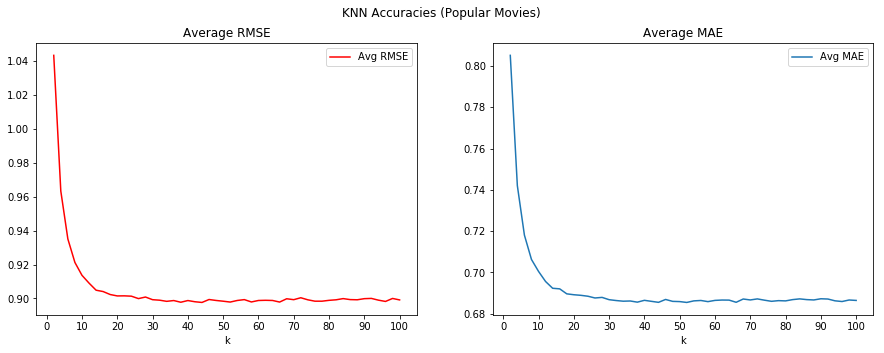

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.suptitle("KNN Accuracies (Popular Movies)")
df_knn_popular_measures[['Avg RMSE']].plot(ax=axes[0], title="Average RMSE", xticks=np.linspace(0,100,11), color='red')
_ = df_knn_popular_measures[['Avg MAE']].plot(ax=axes[1], title="Average MAE", xticks=np.linspace(0,100,11))

In [19]:
print('The  minimum average RMSE is: %4.6f'%df_knn_popular_measures['Avg RMSE'].min())

The  minimum average RMSE is: 0.897657


<h1>Question 13</h1>

In [11]:
df_knn_unpopular_measures = pd.DataFrame(columns=cols)

for knn_k in log_progress(k_list):
    
    test_rmse = np.array([])
    test_mae = np.array([])

    # do cross validation with trimmed test set
    acc = cross_validate_and_score(knn_k, KFold(n_splits=10), trim_popular)
        
    df_knn_unpopular_measures = df_knn_unpopular_measures.append({cols[0]:knn_k,
                                      cols[1]:acc['test_rmse_avg'],
                                      cols[2]:acc['test_mae_avg']},
                                     ignore_index=True)
df_knn_unpopular_measures.set_index('k', inplace=True)

In [12]:
df_knn_unpopular_measures[0:20]

Avg RMSE   Avg MAE
k                       
2.0   1.185507  0.917864
4.0   1.184149  0.915962
6.0   1.183883  0.914927
8.0   1.184027  0.918405
10.0  1.179702  0.911873
12.0  1.184557  0.917508
14.0  1.179057  0.912027
16.0  1.176750  0.907785
18.0  1.183941  0.919019
20.0  1.184841  0.916903

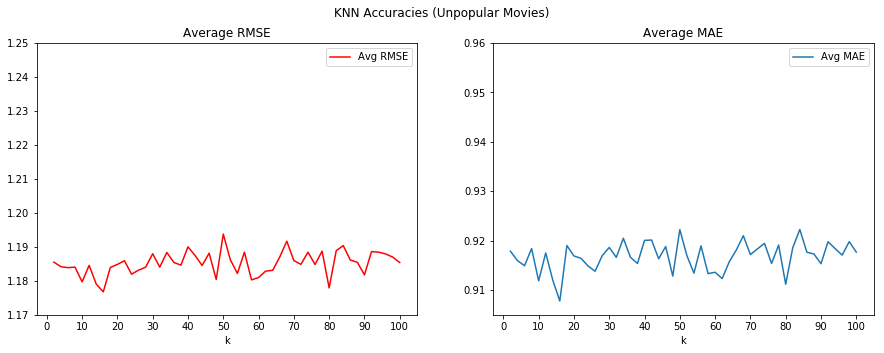

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.suptitle("KNN Accuracies (Unpopular Movies)")
df_knn_unpopular_measures[['Avg RMSE']].plot(ax=axes[0], title="Average RMSE", ylim=(1.17, 1.25), xticks=np.linspace(0,100,11), color='red')
_ = df_knn_unpopular_measures[['Avg MAE']].plot(ax=axes[1], title="Average MAE", ylim=(0.905, 0.96), xticks=np.linspace(0,100,11))

In [17]:
print('The  minimum average RMSE is: %4.6f'%df_knn_unpopular_measures['Avg RMSE'].min())

The  minimum average RMSE is: 1.176750


<h1>Question 14</h1>

In [10]:
df_knn_high_var_measures = pd.DataFrame(columns=cols)

for knn_k in log_progress(k_list):
    
    test_rmse = np.array([])
    test_mae = np.array([])

    # do cross validation with trimmed test set
    acc = cross_validate_and_score(knn_k, KFold(n_splits=10), trim_low_variance)
        
    df_knn_high_var_measures = df_knn_high_var_measures.append({cols[0]:knn_k,
                                      cols[1]:acc['test_rmse_avg'],
                                      cols[2]:acc['test_mae_avg']},
                                     ignore_index=True)
df_knn_high_var_measures.set_index('k', inplace=True)

In [11]:
df_knn_high_var_measures[0:20]

Avg RMSE   Avg MAE
k                       
2.0   1.646141  1.298967
4.0   1.536902  1.232886
6.0   1.557874  1.243973
8.0   1.559324  1.259022
10.0  1.551214  1.231823
12.0  1.550977  1.256745
14.0  1.548466  1.243205
16.0  1.579860  1.278590
18.0  1.576033  1.272548
20.0  1.558328  1.259116

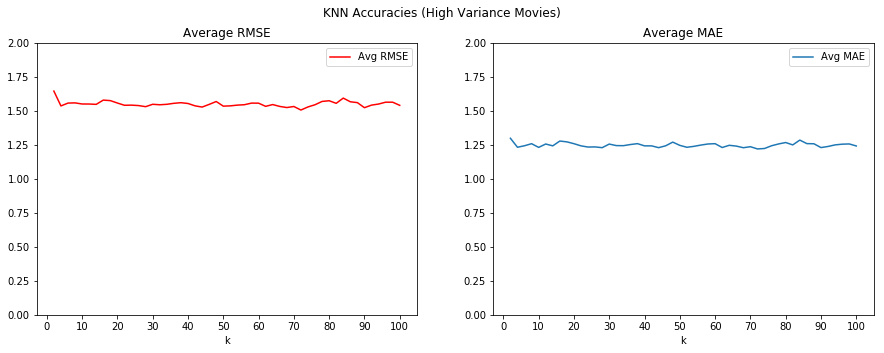

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.suptitle("KNN Accuracies (High Variance Movies)")
df_knn_high_var_measures[['Avg RMSE']].plot(ax=axes[0], title="Average RMSE", ylim=(0.0, 2.0), xticks=np.linspace(0,100,11), color='red')
_ = df_knn_high_var_measures[['Avg MAE']].plot(ax=axes[1], title="Average MAE", ylim=(0.0, 2.0), xticks=np.linspace(0,100,11))

In [15]:
print('The  minimum average RMSE is: %4.6f'%df_knn_high_var_measures['Avg RMSE'].min())

The  minimum average RMSE is: 1.506753
